### Dataset

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
from tqdm import tqdm, tqdm_notebook, trange
from skimage.transform import resize
from skimage.io import imread
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.nn as nn
from PIL import Image
import pandas as pd

In [ ]:
image_files = []
images = []
ROOT = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(ROOT, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        image_files.append(os.path.join(root, files[0]))
        images.append(imread(os.path.join(root, files[0])))

In [ ]:
labels = pd.read_excel(os.path.join(ROOT, 'PH2_dataset.xlsx'), skiprows=12)
labels = labels[['Image Name', 'Melanoma']]
labels['Melanoma'] = labels['Melanoma'].notnull().astype('int')

image_filenames = [os.path.basename(f)[:6] for f in image_files]
sorterIndex = dict(zip(image_filenames, range(len(image_filenames))))
labels['rank'] = labels['Image Name'].map(sorterIndex)
labels = labels.sort_values(by=['rank'])
labels = labels['Melanoma'].tolist()

Изображения имеют разные размеры. Изменяем их размер на $256\times256 $ пикселей.


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val']
# все изображения будут масштабированы к размеру 256x256 px
RESCALE_SIZE = (256, 256)
# работаем на видеокарте
# DEVICE = torch.device("cuda")

In [ ]:
X = [resize(x, RESCALE_SIZE, mode='constant', anti_aliasing=True) for x in images]

In [ ]:
X = np.array(X, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
X.shape

(200, 256, 256, 3)

In [ ]:
class ImagesDataset(Dataset):
    """
    Датасет с картинками, который подгружает их из папок,
    производит скалирование, нормализацию и превращение в торчевые тензоры
    """
    def __init__(self, image_files, labels, mode):
        super().__init__()
        # режим работы
        self.mode = mode
        self.image_files = image_files
        self.labels = labels

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.image_files)

    def _load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _transform(self, image):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(RESCALE_SIZE),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        tensor = transform(image)
        return tensor

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        image = self._load_sample(self.image_files[index % len(self.image_files)])
        image = self._transform(image)
        label = self.labels[index % len(self.labels)]
        return image, label

Чтобы убедиться, что все корректно, нарисуем несколько изображений

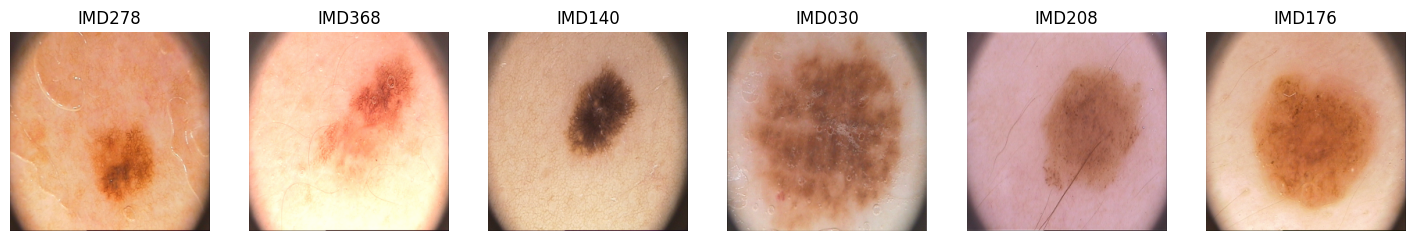

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.title(image_filenames[i])
    plt.axis("off")
    plt.imshow(X[i])

plt.show();

In [ ]:
train_dataset = ImagesDataset(image_files, labels, mode='train')
len(train_dataset)

200

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


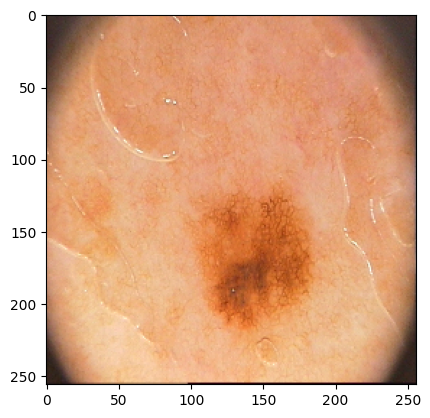

In [ ]:
imshow(train_dataset[0][0])

### Model training

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files, train_labels, val_labels = train_test_split(image_files, labels, test_size=0.2, stratify=labels)
len(train_files), len(val_files), len(train_labels), len(val_labels)

(160, 40, 160, 40)

In [ ]:
train_dataset = ImagesDataset(train_files, train_labels, mode='train')
val_dataset = ImagesDataset(val_files, val_labels, mode='val')
len(train_dataset), len(val_dataset)

(160, 40)

In [ ]:
val_files

['PH2Dataset/PH2 Dataset images/IMD197/IMD197_Dermoscopic_Image/IMD197.bmp',
 'PH2Dataset/PH2 Dataset images/IMD042/IMD042_Dermoscopic_Image/IMD042.bmp',
 'PH2Dataset/PH2 Dataset images/IMD020/IMD020_Dermoscopic_Image/IMD020.bmp',
 'PH2Dataset/PH2 Dataset images/IMD219/IMD219_Dermoscopic_Image/IMD219.bmp',
 'PH2Dataset/PH2 Dataset images/IMD171/IMD171_Dermoscopic_Image/IMD171.bmp',
 'PH2Dataset/PH2 Dataset images/IMD010/IMD010_Dermoscopic_Image/IMD010.bmp',
 'PH2Dataset/PH2 Dataset images/IMD382/IMD382_Dermoscopic_Image/IMD382.bmp',
 'PH2Dataset/PH2 Dataset images/IMD103/IMD103_Dermoscopic_Image/IMD103.bmp',
 'PH2Dataset/PH2 Dataset images/IMD436/IMD436_Dermoscopic_Image/IMD436.bmp',
 'PH2Dataset/PH2 Dataset images/IMD413/IMD413_Dermoscopic_Image/IMD413.bmp',
 'PH2Dataset/PH2 Dataset images/IMD395/IMD395_Dermoscopic_Image/IMD395.bmp',
 'PH2Dataset/PH2 Dataset images/IMD138/IMD138_Dermoscopic_Image/IMD138.bmp',
 'PH2Dataset/PH2 Dataset images/IMD403/IMD403_Dermoscopic_Image/IMD403.bmp',

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(DEVICE)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train(True)
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)


    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # оптимизатор Адам
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        # планировщик для изменения lr
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)
        # Кросс-энтропия в качестве лосса
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if best_acc < val_acc:
                best_model_wts = model.state_dict()
                best_acc = val_acc

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))


    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
model, history = train(train_dataset, val_dataset, model=model, epochs=25, batch_size=64)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


loss 0.48606706261634824


epoch:   4%|▍         | 1/25 [00:09<03:48,  9.51s/it]


Epoch 001 train_loss: 0.4861     val_loss 1.9232 train_acc 0.8000 val_acc 0.8000
loss 0.1808475024998188


epoch:   8%|▊         | 2/25 [00:12<02:04,  5.41s/it]


Epoch 002 train_loss: 0.1808     val_loss 2.4280 train_acc 0.9375 val_acc 0.8000
loss 0.5535508006811142


epoch:  12%|█▏        | 3/25 [00:14<01:29,  4.09s/it]


Epoch 003 train_loss: 0.5536     val_loss 3.2711 train_acc 0.8812 val_acc 0.8250
loss 0.13502228111028672


epoch:  16%|█▌        | 4/25 [00:16<01:10,  3.37s/it]


Epoch 004 train_loss: 0.1350     val_loss 3.1464 train_acc 0.9500 val_acc 0.8500
loss 0.02012627702206373


epoch:  20%|██        | 5/25 [00:19<00:59,  2.99s/it]


Epoch 005 train_loss: 0.0201     val_loss 1.8755 train_acc 1.0000 val_acc 0.9000
loss 0.011270884051918983


epoch:  24%|██▍       | 6/25 [00:21<00:52,  2.75s/it]


Epoch 006 train_loss: 0.0113     val_loss 1.3604 train_acc 1.0000 val_acc 0.9250
loss 0.01299586622044444


epoch:  28%|██▊       | 7/25 [00:23<00:47,  2.64s/it]


Epoch 007 train_loss: 0.0130     val_loss 1.0982 train_acc 0.9938 val_acc 0.9250
loss 0.01261433893814683


epoch:  32%|███▏      | 8/25 [00:26<00:45,  2.66s/it]


Epoch 008 train_loss: 0.0126     val_loss 0.9136 train_acc 1.0000 val_acc 0.9250
loss 0.0047356141731143


epoch:  36%|███▌      | 9/25 [00:28<00:40,  2.52s/it]


Epoch 009 train_loss: 0.0047     val_loss 0.7621 train_acc 1.0000 val_acc 0.9250
loss 0.002996434085071087


epoch:  40%|████      | 10/25 [00:30<00:36,  2.43s/it]


Epoch 010 train_loss: 0.0030     val_loss 0.6740 train_acc 1.0000 val_acc 0.9250
loss 0.013976827822625637


epoch:  44%|████▍     | 11/25 [00:33<00:33,  2.37s/it]


Epoch 011 train_loss: 0.0140     val_loss 0.6118 train_acc 0.9938 val_acc 0.9250
loss 0.00809397608973086


epoch:  48%|████▊     | 12/25 [00:35<00:30,  2.34s/it]


Epoch 012 train_loss: 0.0081     val_loss 0.5745 train_acc 1.0000 val_acc 0.9250
loss 0.006979164015501737


epoch:  52%|█████▏    | 13/25 [00:38<00:29,  2.49s/it]


Epoch 013 train_loss: 0.0070     val_loss 0.5469 train_acc 1.0000 val_acc 0.9250
loss 0.0033295531757175922


epoch:  56%|█████▌    | 14/25 [00:41<00:29,  2.71s/it]


Epoch 014 train_loss: 0.0033     val_loss 0.5356 train_acc 1.0000 val_acc 0.9250
loss 0.0033785664360038935


epoch:  60%|██████    | 15/25 [00:43<00:26,  2.60s/it]


Epoch 015 train_loss: 0.0034     val_loss 0.5232 train_acc 1.0000 val_acc 0.9250
loss 0.007793903816491365


epoch:  64%|██████▍   | 16/25 [00:46<00:22,  2.50s/it]


Epoch 016 train_loss: 0.0078     val_loss 0.5132 train_acc 1.0000 val_acc 0.9250
loss 0.007770053017884493


epoch:  68%|██████▊   | 17/25 [00:48<00:19,  2.49s/it]


Epoch 017 train_loss: 0.0078     val_loss 0.5105 train_acc 1.0000 val_acc 0.9250
loss 0.0033419333398342133


epoch:  72%|███████▏  | 18/25 [00:51<00:17,  2.56s/it]


Epoch 018 train_loss: 0.0033     val_loss 0.5089 train_acc 1.0000 val_acc 0.9250
loss 0.00310952952131629


epoch:  76%|███████▌  | 19/25 [00:53<00:14,  2.46s/it]


Epoch 019 train_loss: 0.0031     val_loss 0.5048 train_acc 1.0000 val_acc 0.9250
loss 0.003129976592026651


epoch:  80%|████████  | 20/25 [00:55<00:11,  2.40s/it]


Epoch 020 train_loss: 0.0031     val_loss 0.5000 train_acc 1.0000 val_acc 0.9250
loss 0.004388582985848188


epoch:  84%|████████▍ | 21/25 [00:58<00:09,  2.35s/it]


Epoch 021 train_loss: 0.0044     val_loss 0.4956 train_acc 1.0000 val_acc 0.9250
loss 0.009965796675533056


epoch:  88%|████████▊ | 22/25 [01:00<00:06,  2.32s/it]


Epoch 022 train_loss: 0.0100     val_loss 0.4909 train_acc 1.0000 val_acc 0.9250
loss 0.004193936381489039


epoch:  92%|█████████▏| 23/25 [01:03<00:05,  2.66s/it]


Epoch 023 train_loss: 0.0042     val_loss 0.4924 train_acc 1.0000 val_acc 0.9250
loss 0.003494114428758621


epoch:  96%|█████████▌| 24/25 [01:07<00:02,  2.90s/it]


Epoch 024 train_loss: 0.0035     val_loss 0.4893 train_acc 1.0000 val_acc 0.9250
loss 0.002831252757459879


epoch: 100%|██████████| 25/25 [01:10<00:00,  2.83s/it]


Epoch 025 train_loss: 0.0028     val_loss 0.4891 train_acc 1.0000 val_acc 0.9250


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=False)

PATH = '/content/gdrive/My Drive/data/resnet_clf.pth'
torch.save(model.state_dict(), PATH)

Mounted at /content/gdrive/


### Predictions

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
files, labels_true = val_dataset.image_files, val_dataset.labels
probs = predict(model, val_loader)
labels_pred = np.argmax(probs, axis=-1)
is_correct = (labels_pred==labels_true)
is_correct

array([ True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256, 256)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

def predict_one_sample(model, img_path, device=DEVICE):
    """Предсказание, для одной картинки"""
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    model.eval()
    logit = model(img).cpu()
    probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

NameError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=False)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = '/content/gdrive/My Drive/data/resnet_clf.pth'
model = models.resnet18()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)
model.load_state_dict(torch.load(PATH, map_location=DEVICE))
model.to(DEVICE)

In [ ]:
PATH = '/content/gdrive/My Drive/data/skin_lesions/8.jpg'
probs = predict_one_sample(model, PATH, )
res = np.argmax(probs)
res

1